In [2]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays

include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")
include("Darcy-2D.jl")
using JLD

LoadError: ArgumentError: Package JLD not found in current path:
- Run `import Pkg; Pkg.add("JLD")` to install the JLD package.


# 2D Darcy Flow

Consider the Darcy flow equation on the two-dimensional spatial domain $D=[0,1]^2$, which describes the pressure field $p(x)$ in a porous medium defined by a positive permeability field $a(x,\theta)$:

$$
\begin{align*}
    -\nabla \cdot (a(x, \theta) \nabla p(x)) &= f(x), \quad &&x\in D,\\
    p(x) &= 0, \quad &&x\in \partial D.
\end{align*}
$$

For simplicity, Dirichlet boundary conditions on the pressure are applied on $\partial D$. The fluid source field $f$ is defined as

$$
\begin{align*}
    f(x_1, x_2) = \begin{cases}
               1000 & 0 \leq x_2 \leq \frac{4}{6}\\
               2000 & \frac{4}{6} < x_2 \leq \frac{5}{6}\\
               3000 & \frac{5}{6} < x_2 \leq 1\\
            \end{cases}. 
\end{align*}
$$



The equation is solved by the finite difference method similar with the [one-dimensional Darcy flow problem](../Posterior/Darcy-1D.ipynb), where computational domain is discretized by a $N \times N$ uniform grid ($N=80$ for the present study).


## Random log-Gaussian Field

Assuming that $\log a(x, \theta)$ is a centred Gaussian with covariance 
$$\mathsf{C} = (-\Delta + \tau^2 )^{-d};$$
here $-\Delta$ denotes the Laplacian on $D$ subject to homogeneous Neumann boundary conditions on the space of spatial-mean zero functions, 
$\tau > 0$ denotes the inverse length scale of the random field and $d  > 0$ determines its regularity.
The Gaussian field can be represented by the Karhunen–Loève (KL) expansion

\begin{equation}
\label{eq:KL-2d}
    \log a(x,\theta) = \sum_{l\in K} \theta_{(l)}\sqrt{\lambda_l} \psi_l(x),
\end{equation}
where $K = \mathcal{Z}^{0+}\times\mathcal{Z}^{0+} \setminus \{0,0\}$, and the eigenpairs are of the form

$$
\begin{equation*}
    \psi_l(x) = \begin{cases}
                 \sqrt{2}\cos(\pi l_1 x_1)              & l_2 = 0\\
                 \sqrt{2}\cos(\pi l_2 x_2)              & l_1 = 0\\
                 2\cos(\pi l_1 x_1)\cos(\pi l_2 x_2)    & \textrm{otherwise}\\
                 \end{cases},
                 \qquad \lambda_l = (\pi^2 |l|^2 + \tau^2)^{-d}
\end{equation*}
$$

and $\theta_{(l)} \sim \mathcal{N}(0,1)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 

$$
\begin{equation}
\label{eq:KL-1d}
    \log a(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}
$$

where the eigenvalues $\lambda_k$ are in descending order.
In practice, we truncate this sum to $N_\theta$ terms, based on the
largest $N_\theta$ eigenvalues, and hence $\theta\in\mathcal{R}^{N_\theta}$.
 


## Inverse Problem Setup

For the inverse problem, we recover the log-permeability field $\log a_{{ref}}(x)$ from the observation 
$y_{ref}$, which consists of pointwise measurements of the 
pressure value $p(x)$ at $49$ equidistant points in the domain. 


We generate a truth random field $\log a_{{ref}}(x)$ with $\theta \sim \mathcal{N}(0, I)$ in $\mathcal{R}^{256}$ 
(i.e. we use the first $256$ KL modes) to construct the observation $y_{obs}$.

$5\%$ Gaussian random noises are added to make data $y_{obs}$:

$$
\begin{equation}
    y_{obs} = y_{ref} + \epsilon \odot  \mathcal{N}(0, I),
\end{equation}
$$

where $\epsilon = 5\% y_{ref}$, and $\odot$ denotes element-wise multiplication.



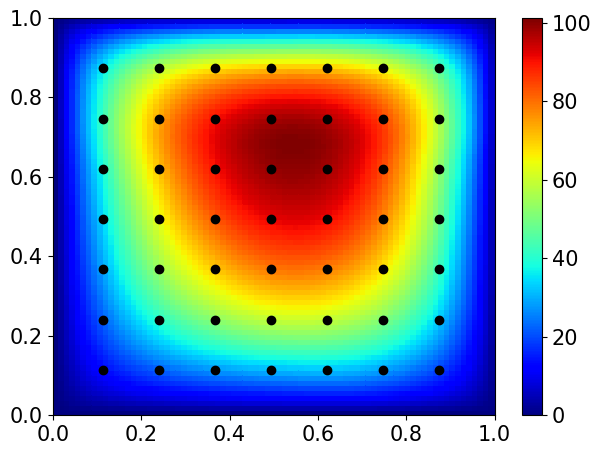

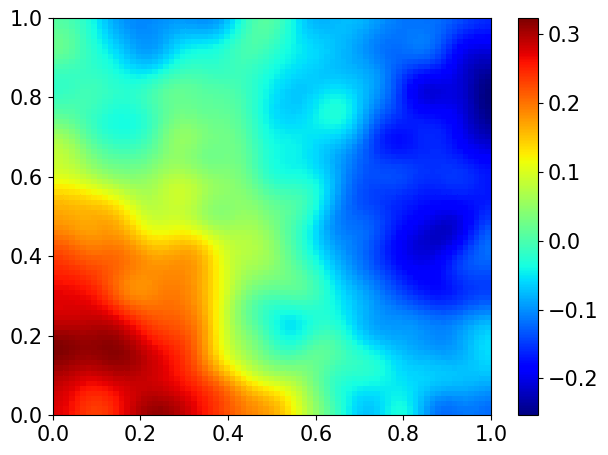

In [3]:
N, L = 80, 1.0
obs_ΔN = 10
d = 2.0
τ = 3.0
N_KL = 256
N_θ = 0
darcy = Setup_Param(N, L, N_KL, obs_ΔN, N_θ, d, τ)

κ_2d = exp.(darcy.logκ_2d)
h_2d = solve_Darcy_2D(darcy, κ_2d)
y_noiseless = compute_obs(darcy, h_2d)

figure(1)
plot_field(darcy, h_2d, true, "Darcy-2D-obs.pdf")
figure(2)
plot_field(darcy, darcy.logκ_2d, false, "Darcy-2D-logk-ref.pdf")
    

## Inverse Problem Setup

Using this data, we consider two incomplete parameterization scenarios:  
* solving for the first $32$ KL modes ($N_\theta=32$) 
* solving for the first $8$ KL modes ($N_\theta=8$).  
        
        
UKI is applied and initialized with $\theta_0 \sim \mathcal{N}(0,  I)$. 
The observation error is estimated to be $\eta \sim \mathcal{N}(0, I)$. 

### $N_\theta = 32$ Case
For the $N_\theta = 32$ case, the convergence of the log-permeability fields $\log a(x, m_n)$ and the optimization errors at each iteration for different noise levels are depicted; 
Without explicit regularization ($\alpha=1.0$), UKI suffers from overfitting for noisy scenarios: the optimization errors keep decreasing, but the parameter errors show the ``U-shape'' characteristic of overfitting. Adding regularization ($\alpha=0.5$) relieves the overfitting.

The estimated log-permeability fields $\log a(x,m_n)$ at the 20th iteration and the truth random field are depicted.  The estimated log-permeability field obtained by regularized UKI captures main features of the truth random field.



In [4]:
# N_θ = 32 case with 5% Gaussian error
N_θ = darcy.N_θ = N_KL
noise_level = 0.05
N_y = length(y_noiseless)
# observation
y = copy(y_noiseless)
Random.seed!(123);
for i = 1:length(y)
    # noise = rand(Normal(0, noise_level*y[i]))
    noise = rand(Normal(0, 1.0))
    y[i] += noise
end
Σ_η = Array(Diagonal(fill(1.0, length(y))))

# initial mean and covariance
θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov = Array(Diagonal(fill(1.0, N_θ)))

aug_y = [y; zeros(Float64, N_θ)] 
aug_Σ_η = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) θθ0_cov]  
darcy.N_y = (N_y + N_θ)

update_freq = 1
N_iter = 10
α_reg = 1.0
ukiobj = UKI_Run(darcy,  aug_forward, θ0_mean, θθ0_cov, aug_y, aug_Σ_η, α_reg, update_freq, N_iter);

##################################################



┌ Info: ("optimization error at iter 1 = ", 348.4942871053528)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 16.0)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 30.39719065060874)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 15.646008398134134)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 29.273303453592312)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 15.594950322273068)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 29.089130578247342)
└ @ Main /Users/huang/Independence

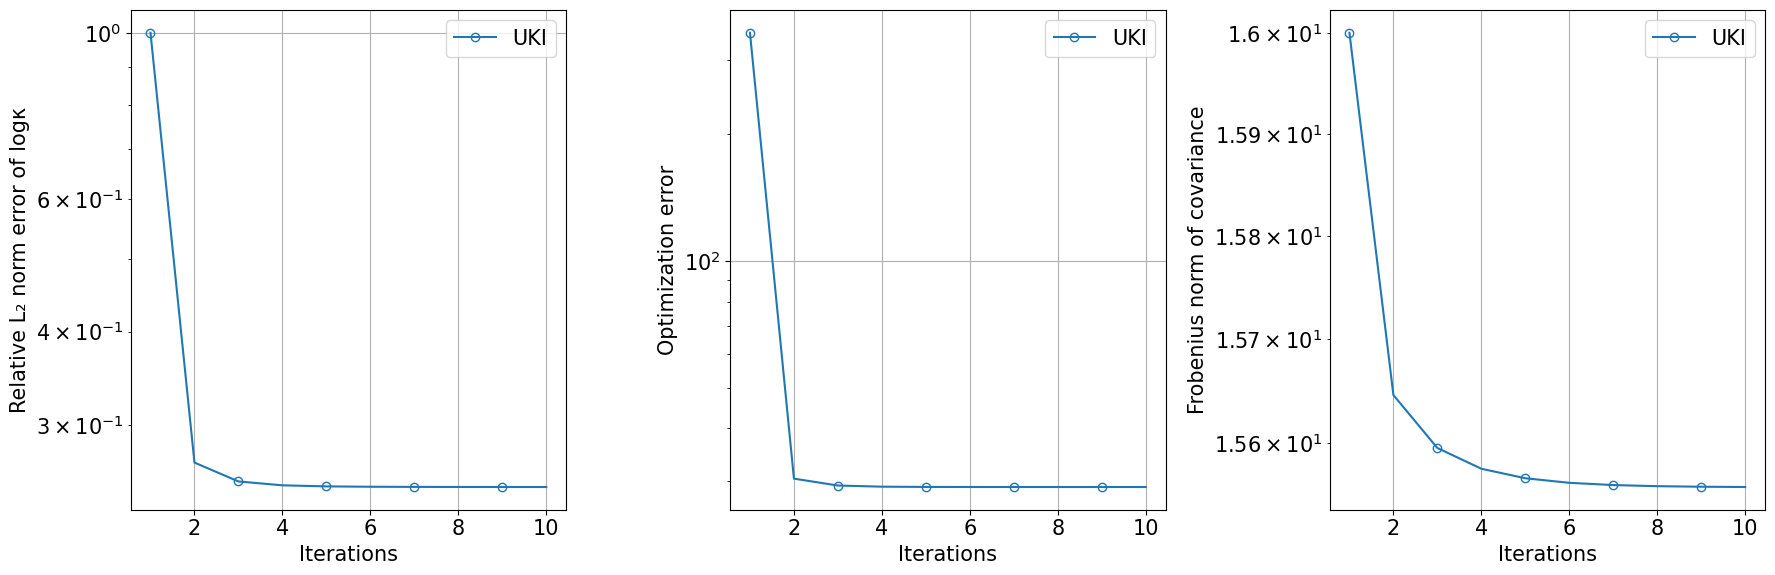

In [5]:
fig, (ax1, ax2, ax3) = PyPlot.subplots(ncols=3, figsize=(18,6))
ites = Array(LinRange(1, N_iter, N_iter))
errors = zeros(Float64, (3, N_iter))
for i = 1:N_iter
    errors[1, i] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ_2d)
    errors[2, i] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y))
    errors[3, i] = norm(ukiobj.θθ_cov[i])
end

ax1.semilogy(ites, errors[1, :], "-o", fillstyle="none", markevery=2, label= "UKI")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Relative L₂ norm error of logκ")
ax1.legend()
ax1.grid(true)

ax2.semilogy(ites, errors[2, :], "-o", fillstyle="none", markevery=2, label= "UKI")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Optimization error")
ax2.grid(true)
ax2.legend()

ax3.semilogy(ites, errors[3, :], "-o", fillstyle="none", markevery=2, label= "UKI")
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.grid(true)
ax3.legend()
fig.tight_layout()
fig.savefig("Darcy-2D-Loss.pdf")
##################################################

# MCMC

In [6]:
# compute posterior distribution by MCMC
# (uninformative) prior mean and covariance
μ0 = θ0_mean # θ_ref #
Σ0 = Array(Diagonal(fill(1.0^2.0, N_θ)))

log_likelihood_func(θ) = log_likelihood(darcy, θ, forward, y,  Σ_η)
N_iter_MCMC , n_burn_in= 2*10^6, 5*10^5
us = PCN_Run(log_likelihood_func, μ0, Σ0, 0.04, N_iter_MCMC);



In [6]:
uki_θ_mean  = ukiobj.θ_mean[end]
uki_θθ_cov = ukiobj.θθ_cov[end]
uki_θθ_std = sqrt.(diag(ukiobj.θθ_cov[end]))

mcmc_θ_mean = mean(us[n_burn_in:N_iter_MCMC, :], dims=1)[:]
mcmc_θθ_std = std(us[n_burn_in:N_iter_MCMC, :], dims=1)[:]

θ_cov_ind = Array(1:div(N_θ*(N_θ+1), 2))
uki_θiθj_cov, mcmc_θiθj_cov = zeros(Float64, div(N_θ*(N_θ+1), 2)), zeros(Float64, div(N_θ*(N_θ+1), 2))
ind_ij = 1
for i = 1:N_θ
    for j = i:N_θ
        global ind_ij
        uki_θiθj_cov[ind_ij]   = uki_θθ_cov[i,j]
        mcmc_θiθj_cov[ind_ij] = (us[n_burn_in:N_iter_MCMC, i] .- mcmc_θ_mean[i])' * (us[n_burn_in:N_iter_MCMC, j] .- mcmc_θ_mean[j])/(N_iter_MCMC - n_burn_in)

        ind_ij += 1
    end
end

save("Darcy-2D.jld2", "mean", mcmc_θ_mean, "std",  mcmc_θθ_std, "cov", mcmc_θiθj_cov)

In [8]:
# uki_θ_mean  = ukiobj.θ_mean[end]
# uki_θθ_cov = ukiobj.θθ_cov[end]
# uki_θθ_std = sqrt.(diag(ukiobj.θθ_cov[end]))

# θ_cov_ind = Array(1:div(N_θ*(N_θ+1), 2))
# uki_θiθj_cov  = zeros(Float64, div(N_θ*(N_θ+1), 2))
# ind_ij = 1
# for i = 1:N_θ
#     for j = i:N_θ
#         global ind_ij
#         uki_θiθj_cov[ind_ij]   = uki_θθ_cov[i,j]
        
#         ind_ij += 1
#     end
# end

# dic = load("Darcy-2D.jld2")
# mcmc_θ_mean = dic["mean"] 
# mcmc_θθ_std = dic["std"] 
# mcmc_θiθj_cov = dic["cov"] 

LoadError: JLD2.InvalidDataException("")

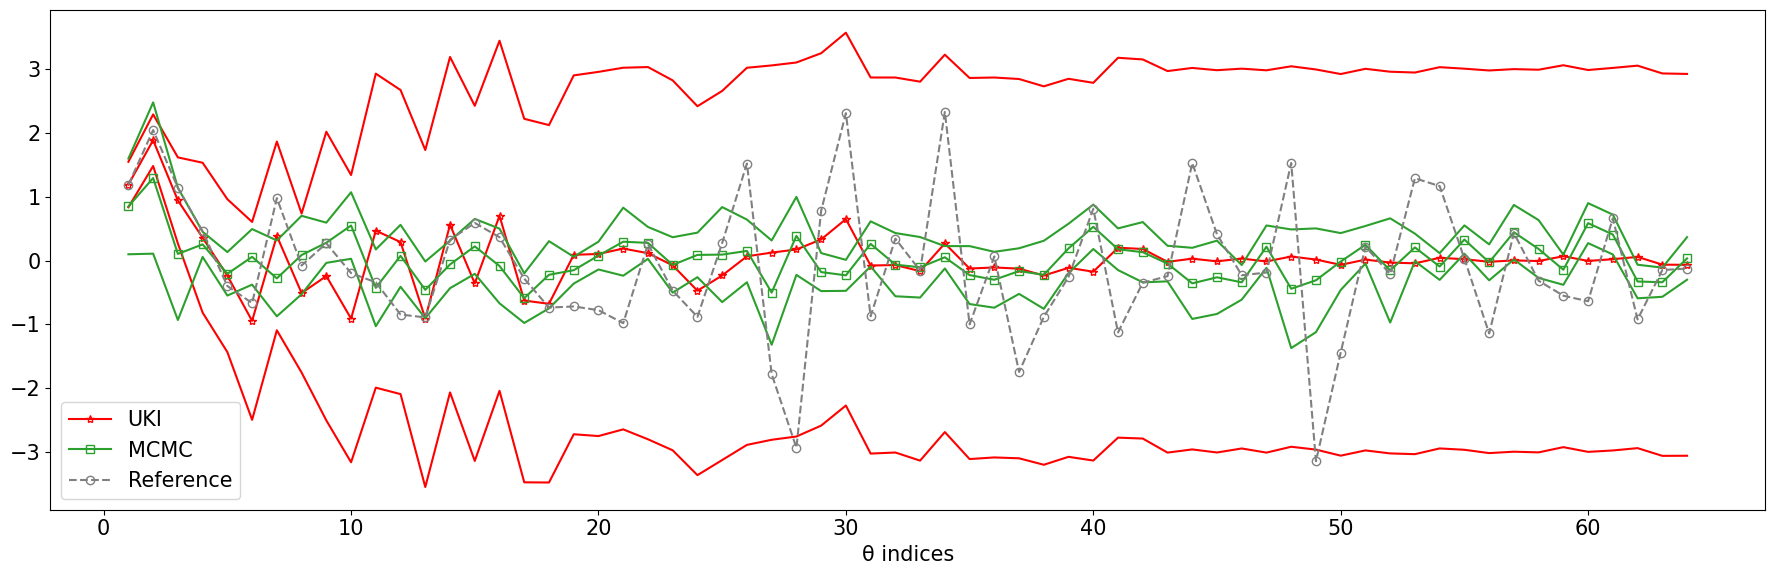

In [7]:
fig, ax = PyPlot.subplots(figsize=(18,6))
θ_ind = Array(1:64) #Array(1:N_θ)
θ_ref = darcy.θ_ref

ax.plot(θ_ind , uki_θ_mean[θ_ind],"-*", color="red", fillstyle="none",  label="UKI")
ax.plot(θ_ind , uki_θ_mean[θ_ind] + 3.0*uki_θθ_std[θ_ind], color="red")
ax.plot(θ_ind , uki_θ_mean[θ_ind] - 3.0*uki_θθ_std[θ_ind], color="red")


ax.plot(θ_ind , mcmc_θ_mean[θ_ind],"-s", color="C2", fillstyle="none" , label="MCMC")
ax.plot(θ_ind , mcmc_θ_mean[θ_ind] + 3.0*mcmc_θθ_std[θ_ind], color ="C2")
ax.plot(θ_ind , mcmc_θ_mean[θ_ind] - 3.0*mcmc_θθ_std[θ_ind], color ="C2")


ax.plot(θ_ind , θ_ref[θ_ind], "--o", color="grey", fillstyle="none", label="Reference")
ax.legend()
# plot MCMC results 
ax.set_xlabel("θ indices")
fig.tight_layout()
fig.savefig("Darcy-2D-theta.pdf")

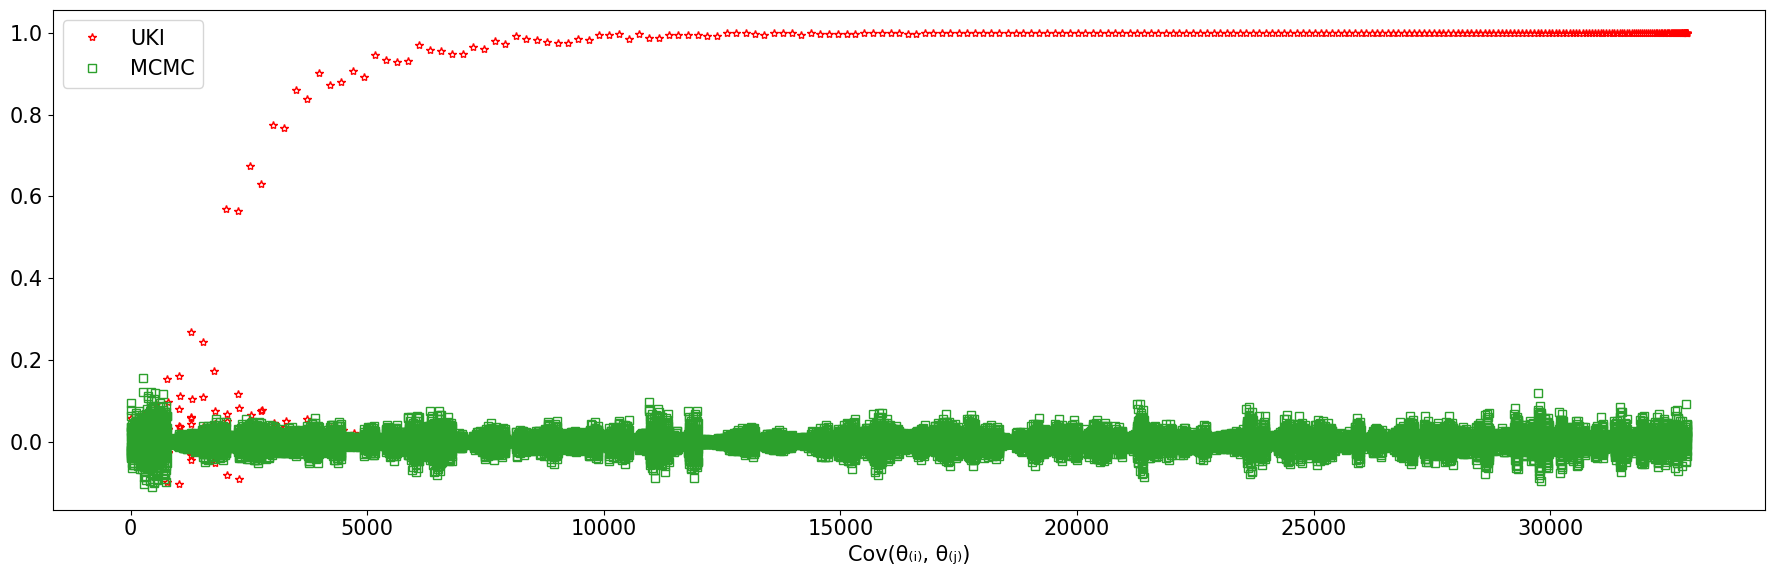

In [8]:
fig, ax = PyPlot.subplots(figsize=(18,6))

θ_ind = Array(1:1000)
ax.plot(θ_cov_ind[θ_ind] , uki_θiθj_cov[θ_ind],  "*", color="red", fillstyle="none",  label="UKI")
ax.plot(θ_cov_ind[θ_ind] , mcmc_θiθj_cov[θ_ind], "s", color="C2",  fillstyle="none" , label="MCMC")


ax.legend()
# plot MCMC results 
ax.set_xlabel("Cov(θ₍ᵢ₎, θ₍ⱼ₎)")
fig.tight_layout()
fig.savefig("Darcy-2D-cov.pdf")

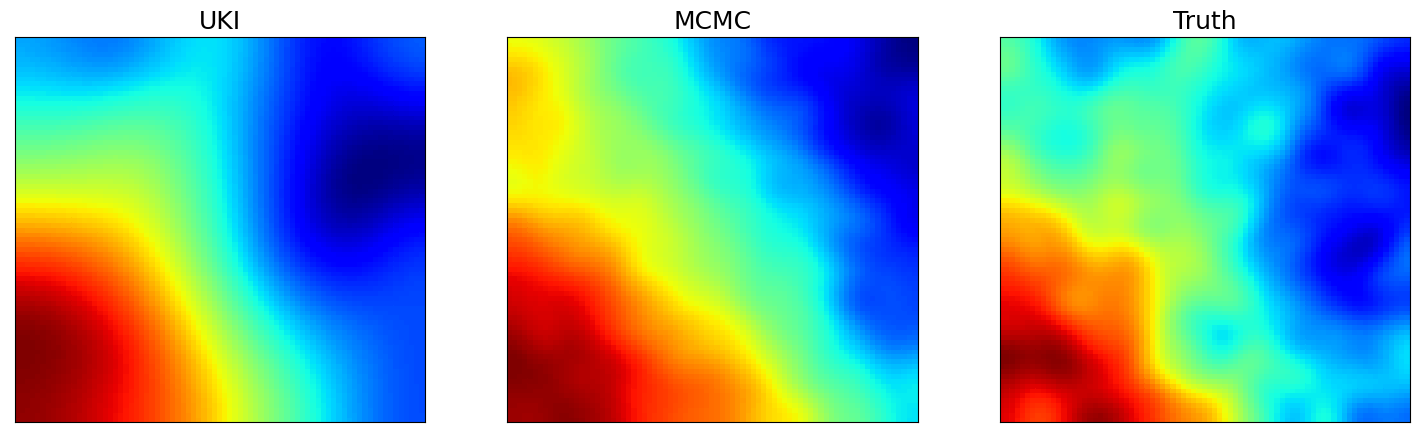

In [9]:
# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 3, sharex=true, sharey=true, figsize=(18,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))
plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[3]) 
plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[end]), color_lim, ax_logk[1]) 

plot_field(darcy, compute_logκ_2d(darcy,  mcmc_θ_mean), color_lim, ax_logk[2]) 
fig_logk.tight_layout()
fig_logk.savefig("Darcy-2D-logk.pdf")